In [12]:
import os

TIMER_SETTING_VALS = [0,1,2]
DROP_RATE_VALS = [25]
TIMER_SCALING_VALS = [3]
DELAY_VALS = [2.5,5,10,20,40]

data = {}
for timer_setting in TIMER_SETTING_VALS:
    data[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            for delay in DELAY_VALS:
                data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][f'delay{delay}'] = {}
                timer_setting_2 = timer_setting
                drop_rate_2 = drop_rate
                timer_scaling_2 = timer_scaling
                delay_2 = delay
                # if drop_rate == 0:
                #     timer_setting_2 = 0
                #     timer_scaling_2 = 2
                # elif timer_setting == 0:
                #     timer_scaling_2 = 2
                directory = f"./log/6/GEANT-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}-delay{delay_2}/stdout"
                for filename in os.listdir(directory):
                    filepath = os.path.join(directory, filename)
                    if os.path.isfile(filepath):
                        nodename = str(filepath).split('/')[-1].split('.')[0]
                        with open(filepath, 'r') as file:
                            data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][f'delay{delay}'][nodename] = [line.strip() for line in file]




In [13]:
sync_interest_counts = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts[timer_setting][drop_rate][timer_scaling] = {}
            for delay in DELAY_VALS:
                sync_interest_counts[timer_setting][drop_rate][timer_scaling][delay] = 0
                timer_setting_2 = timer_setting
                drop_rate_2 = drop_rate
                timer_scaling_2 = timer_scaling
                delay_2 = delay
                # if timer_setting == 0 and timer_scaling > 2:
                #     timer_scaling_2 = 2
                for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'][f'delay{delay_2}'].items():
                    sync_interest_counts[timer_setting][drop_rate][timer_scaling][delay] += log.count('Sending Sync interest')

In [14]:
sync_interest_counts

{0: {25: {3: {2.5: 1687, 5: 1724, 10: 1869, 20: 2051, 40: 2878}}},
 1: {25: {3: {2.5: 1636, 5: 1733, 10: 1626, 20: 1670, 40: 1919}}},
 2: {25: {3: {2.5: 1731, 5: 1679, 10: 1764, 20: 1659, 40: 1898}}}}

In [15]:
import numpy as np

sync_latencies = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies[timer_setting][drop_rate][timer_scaling] = {}
            for delay in DELAY_VALS:
                sync_latencies[timer_setting][drop_rate][timer_scaling][delay] = 0
                timer_setting_2 = timer_setting
                drop_rate_2 = drop_rate
                timer_scaling_2 = timer_scaling
                delay_2 = delay
                # if timer_setting == 0 and timer_scaling > 2:
                #     timer_scaling_2 = 2
                latencies = []
                for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'][f'delay{delay_2}'].items():
                    log_publishes = [s for s in log if s.startswith('Published')]
                    for log_pub in log_publishes:
                        send_timestamp = int(log_pub.split(',')[1].strip())
                        update = log_pub.split(',')[0].split('/')[-1].strip()
                        recv_max_time_list = []
                        for recv_nodename, recv_log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'][f'delay{delay_2}'].items():
                            if recv_nodename == nodename:
                                continue
                            log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                            if len(log_recv_list) > 0:
                                log_recv = log_recv_list[0]
                                recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                        if len(recv_max_time_list) > 0:
                            latencies.append(np.percentile(recv_max_time_list, 90))
                sync_latencies[timer_setting][drop_rate][timer_scaling][delay] = sum(latencies) / len(latencies)


In [16]:
sync_latencies

{0: {25: {3: {2.5: 2125.2727777777773,
    5: 1990.0411111111061,
    10: 1918.8793055555518,
    20: 2146.474583333331,
    40: 1794.9073611111075}}},
 1: {25: {3: {2.5: 2328.19861111111,
    5: 2190.1661111111066,
    10: 1909.2115277777739,
    20: 2108.055833333329,
    40: 2274.3589707927617}}},
 2: {25: {3: {2.5: 2053.5477777777746,
    5: 2060.61819444444,
    10: 1819.734305555551,
    20: 2139.5520833333294,
    40: 2375.8166898470076}}}}

In [17]:
from matplotlib import pyplot as plt

delays = [2.5,5,10,20,40]
latencies = {}
for timer_setting, latency_data in sync_latencies.items():
    latencies[timer_setting] = [value for _, value in latency_data[25][3].items()]
overheads = {}
for timer_setting, overhead_data in sync_interest_counts.items():
    overheads[timer_setting] = [value for _, value in overhead_data[25][3].items()]


([<matplotlib.axis.XTick at 0x12e91a250>,
 [Text(2.5, 0, '2.5'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40')])

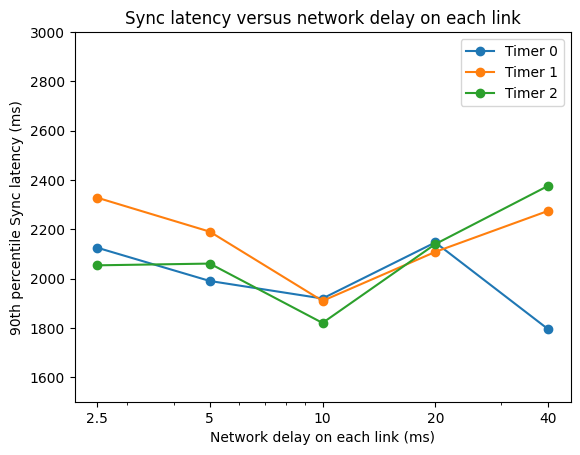

In [18]:
plt.figure()
plt.title('Sync latency versus network delay on each link')
for timer_setting in latencies.keys():
    plt.plot(delays, latencies[timer_setting], 'o-', label=f'Timer {timer_setting}')
plt.legend()
plt.xlabel('Network delay on each link (ms)')
plt.ylabel('90th percentile Sync latency (ms)')
plt.ylim(1500, 3000)
plt.xscale('log')
plt.xticks(delays, delays)

(1000.0, 3500.0)

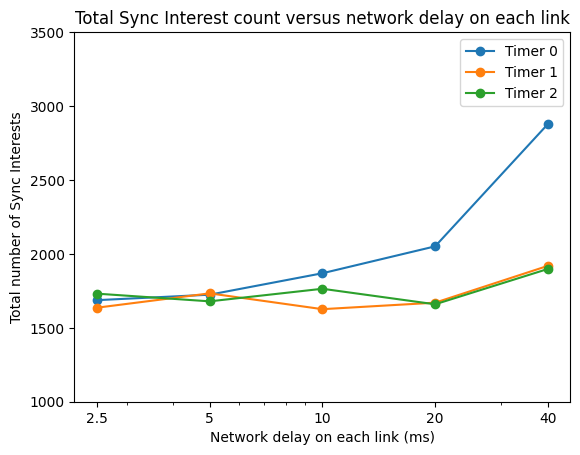

In [19]:
plt.figure()
plt.title('Total Sync Interest count versus network delay on each link')
for timer_setting in overheads.keys():
    plt.plot(delays, overheads[timer_setting], 'o-', label=f'Timer {timer_setting}')
plt.legend()
plt.xlabel('Network delay on each link (ms)')
plt.ylabel('Total number of Sync Interests')
plt.xscale('log')
plt.xticks(delays, delays)
plt.ylim(1000, 3500)

In [168]:
TIMER_SETTING_VALS = [0,1,2]
DROP_RATE_VALS = [25]
TIMER_SCALING_VALS = [1,2,3,4,5]

data = {}
for timer_setting in TIMER_SETTING_VALS:
    data[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            if drop_rate == 0:
                timer_setting_2 = 0
                timer_scaling_2 = 1
            elif timer_setting == 0:
                timer_scaling_2 = 2
            directory = f"./log/2/GEANT-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}/stdout"
            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if os.path.isfile(filepath):
                    nodename = str(filepath).split('/')[-1].split('.')[0]
                    with open(filepath, 'r') as file:
                        data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][nodename] = [line.strip() for line in file]

In [174]:
sync_interest_counts = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                sync_interest_counts[timer_setting][drop_rate][timer_scaling] += log.count('Sending Sync interest')

In [175]:
sync_interest_counts

{0: {25: {1: 1869, 2: 1869, 3: 1869, 4: 1869, 5: 1869}},
 1: {25: {1: 2610, 2: 1875, 3: 1890, 4: 1703, 5: 1726}},
 2: {25: {1: 2295, 2: 2021, 3: 1851, 4: 1585, 5: 1700}}}

In [176]:
sync_latencies = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            latencies = []
            for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                log_publishes = [s for s in log if s.startswith('Published')]
                for log_pub in log_publishes:
                    send_timestamp = int(log_pub.split(',')[1].strip())
                    update = log_pub.split(',')[0].split('/')[-1].strip()
                    recv_max_time_list = []
                    for recv_nodename, recv_log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                        if recv_nodename == nodename:
                            continue
                        log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                        if len(log_recv_list) > 0:
                            log_recv = log_recv_list[0]
                            recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                    if len(recv_max_time_list) > 0:
                        latencies.append(np.percentile(recv_max_time_list, 90))
            sync_latencies[timer_setting][drop_rate][timer_scaling] = sum(latencies) / len(latencies)

In [177]:
sync_latencies

{0: {25: {1: 1918.8793055555518,
   2: 1918.8793055555518,
   3: 1918.8793055555518,
   4: 1918.8793055555518,
   5: 1918.8793055555518}},
 1: {25: {1: 2145.755416666661,
   2: 2071.717916666663,
   3: 2298.785138888884,
   4: 2484.766388888884,
   5: 3118.9247566063978}},
 2: {25: {1: 2037.4140472878944,
   2: 2173.536527777772,
   3: 2178.980555555547,
   4: 2098.5368055555496,
   5: 2155.2088888888816}}}

In [178]:
scaling = [1,2,3,4,5]
latencies = {}
for timer_setting, latency_data in sync_latencies.items():
    latencies[timer_setting] = [value for _, value in latency_data[25].items()]
overheads = {}
for timer_setting, overhead_data in sync_interest_counts.items():
    overheads[timer_setting] = [value for _, value in overhead_data[25].items()]

([<matplotlib.axis.XTick at 0x2881d91d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

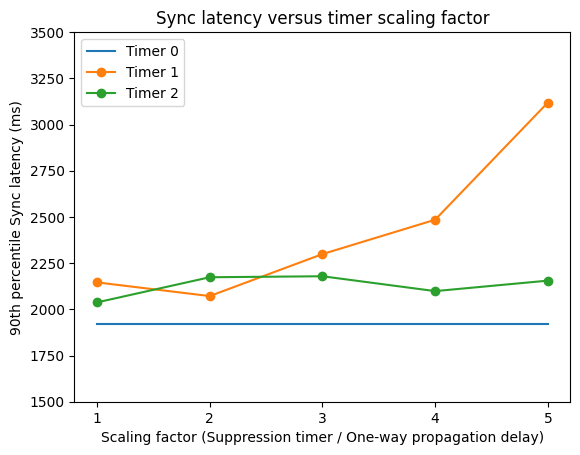

In [182]:
plt.figure()
plt.title('Sync latency versus timer scaling factor')
for timer_setting in latencies.keys():
    if timer_setting == 0:
        plt.plot(scaling, latencies[timer_setting], '-', label=f'Timer {timer_setting}')
    else:
        plt.plot(scaling, latencies[timer_setting], 'o-', label=f'Timer {timer_setting}')
    
plt.legend()
plt.xlabel('Scaling factor (Suppression timer / One-way propagation delay)')
plt.ylabel('90th percentile Sync latency (ms)')
plt.ylim(1500, 3500)
plt.xticks(scaling, scaling)

([<matplotlib.axis.XTick at 0x28a93c610>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

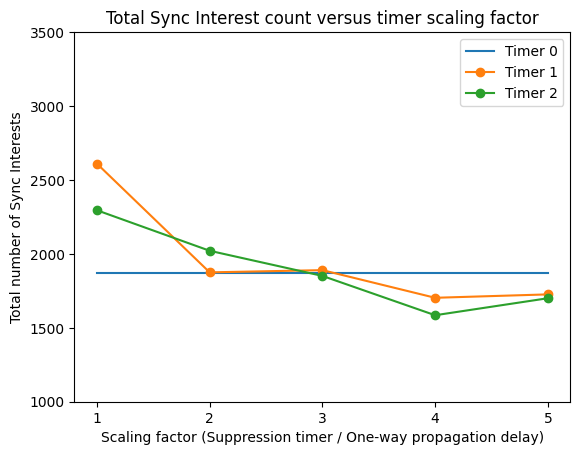

In [183]:
plt.figure()
plt.title('Total Sync Interest count versus timer scaling factor')
for timer_setting in overheads.keys():
    if timer_setting == 0:
        plt.plot(scaling, overheads[timer_setting], '-', label=f'Timer {timer_setting}')
    else:
        plt.plot(scaling, overheads[timer_setting], 'o-', label=f'Timer {timer_setting}')
plt.legend()
plt.xlabel('Scaling factor (Suppression timer / One-way propagation delay)')
plt.ylabel('Total number of Sync Interests')
plt.ylim(1000, 3500)
plt.xticks(scaling, scaling)

In [2]:
import os

TIMER_SETTING_VALS = [0,1,2]
DROP_RATE_VALS = [0,25,50]
TIMER_SCALING_VALS = [3]

data = {}
for timer_setting in TIMER_SETTING_VALS:
    data[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            if drop_rate == 0:
                timer_setting_2 = 0
                timer_scaling_2 = 2
            elif timer_setting == 0:
                timer_scaling_2 = 2
            directory = f"./log/5/GEANT-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}/stdout"
            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if os.path.isfile(filepath):
                    nodename = str(filepath).split('/')[-1].split('.')[0]
                    with open(filepath, 'r') as file:
                        data[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][nodename] = [line.strip() for line in file]

data_12 = {}
for timer_setting in TIMER_SETTING_VALS:
    data_12[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data_12[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data_12[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            if drop_rate == 0:
                timer_setting_2 = 0
                timer_scaling_2 = 2
            elif timer_setting == 0:
                timer_scaling_2 = 2
            directory = f"./log/5/GEANT12-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}/stdout"
            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if os.path.isfile(filepath):
                    nodename = str(filepath).split('/')[-1].split('.')[0]
                    with open(filepath, 'r') as file:
                        data_12[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][nodename] = [line.strip() for line in file]

data_24 = {}
for timer_setting in TIMER_SETTING_VALS:
    data_24[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data_24[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data_24[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            if drop_rate == 0:
                timer_setting_2 = 0
                timer_scaling_2 = 2
            elif timer_setting == 0:
                timer_scaling_2 = 2
            directory = f"./log/5/GEANT24-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}/stdout"
            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if os.path.isfile(filepath):
                    nodename = str(filepath).split('/')[-1].split('.')[0]
                    with open(filepath, 'r') as file:
                        data_24[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][nodename] = [line.strip() for line in file]

data_37 = {}
for timer_setting in TIMER_SETTING_VALS:
    data_37[f'timer{timer_setting}'] = {}
    for drop_rate in DROP_RATE_VALS:
        data_37[f'timer{timer_setting}'][f'drop{drop_rate}'] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            data_37[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'] = {}
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            if drop_rate == 0:
                timer_setting_2 = 0
                timer_scaling_2 = 2
            elif timer_setting == 0:
                timer_scaling_2 = 2
            directory = f"./log/5/GEANT37-timer{timer_setting_2}-drop{drop_rate_2}-scaling{timer_scaling_2}/stdout"
            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if os.path.isfile(filepath):
                    nodename = str(filepath).split('/')[-1].split('.')[0]
                    with open(filepath, 'r') as file:
                        data_37[f'timer{timer_setting}'][f'drop{drop_rate}'][f'scaling{timer_scaling}'][nodename] = [line.strip() for line in file]

In [3]:
sync_interest_counts = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                sync_interest_counts[timer_setting][drop_rate][timer_scaling] += log.count('Sending Sync interest')

sync_interest_counts_12 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts_12[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts_12[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts_12[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            for nodename, log in data_12[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                sync_interest_counts_12[timer_setting][drop_rate][timer_scaling] += log.count('Sending Sync interest')

sync_interest_counts_24 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts_24[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts_24[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts_24[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            for nodename, log in data_24[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                sync_interest_counts_24[timer_setting][drop_rate][timer_scaling] += log.count('Sending Sync interest')

sync_interest_counts_37 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_interest_counts_37[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_interest_counts_37[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_interest_counts_37[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            for nodename, log in data_37[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                sync_interest_counts_37[timer_setting][drop_rate][timer_scaling] += log.count('Sending Sync interest')



In [4]:
sync_interest_counts_37

{0: {0: {3: 766}, 25: {3: 3331}, 50: {3: 2696}},
 1: {0: {3: 766}, 25: {3: 3011}, 50: {3: 2658}},
 2: {0: {3: 766}, 25: {3: 3280}, 50: {3: 2722}}}

In [6]:
import numpy as np

sync_latencies = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            latencies = []
            for nodename, log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                log_publishes = [s for s in log if s.startswith('Published')]
                for log_pub in log_publishes:
                    send_timestamp = int(log_pub.split(',')[1].strip())
                    update = log_pub.split(',')[0].split('/')[-1].strip()
                    recv_max_time_list = []
                    for recv_nodename, recv_log in data[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                        if recv_nodename == nodename:
                            continue
                        log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                        if len(log_recv_list) > 0:
                            log_recv = log_recv_list[0]
                            recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                    if len(recv_max_time_list) > 0:
                        latencies.append(np.percentile(recv_max_time_list, 90))
            sync_latencies[timer_setting][drop_rate][timer_scaling] = sum(latencies) / len(latencies)

sync_latencies_12 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies_12[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies_12[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies_12[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            latencies = []
            for nodename, log in data_12[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                log_publishes = [s for s in log if s.startswith('Published')]
                for log_pub in log_publishes:
                    send_timestamp = int(log_pub.split(',')[1].strip())
                    update = log_pub.split(',')[0].split('/')[-1].strip()
                    recv_max_time_list = []
                    for recv_nodename, recv_log in data_12[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                        if recv_nodename == nodename:
                            continue
                        log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                        if len(log_recv_list) > 0:
                            log_recv = log_recv_list[0]
                            recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                    if len(recv_max_time_list) > 0:
                        latencies.append(np.percentile(recv_max_time_list, 90))
            sync_latencies_12[timer_setting][drop_rate][timer_scaling] = sum(latencies) / len(latencies)

sync_latencies_24 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies_24[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies_24[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies_24[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            latencies = []
            for nodename, log in data_24[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                log_publishes = [s for s in log if s.startswith('Published')]
                for log_pub in log_publishes:
                    send_timestamp = int(log_pub.split(',')[1].strip())
                    update = log_pub.split(',')[0].split('/')[-1].strip()
                    recv_max_time_list = []
                    for recv_nodename, recv_log in data_24[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                        if recv_nodename == nodename:
                            continue
                        log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                        if len(log_recv_list) > 0:
                            log_recv = log_recv_list[0]
                            recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                    if len(recv_max_time_list) > 0:
                        latencies.append(np.percentile(recv_max_time_list, 90))
            sync_latencies_24[timer_setting][drop_rate][timer_scaling] = sum(latencies) / len(latencies)

sync_latencies_37 = {}
for timer_setting in TIMER_SETTING_VALS:
    sync_latencies_37[timer_setting] = {}
    for drop_rate in DROP_RATE_VALS:
        sync_latencies_37[timer_setting][drop_rate] = {}
        for timer_scaling in TIMER_SCALING_VALS:
            sync_latencies_37[timer_setting][drop_rate][timer_scaling] = 0
            timer_setting_2 = timer_setting
            drop_rate_2 = drop_rate
            timer_scaling_2 = timer_scaling
            # if timer_setting == 0 and timer_scaling > 2:
            #     timer_scaling_2 = 2
            latencies = []
            for nodename, log in data_37[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                log_publishes = [s for s in log if s.startswith('Published')]
                for log_pub in log_publishes:
                    send_timestamp = int(log_pub.split(',')[1].strip())
                    update = log_pub.split(',')[0].split('/')[-1].strip()
                    recv_max_time_list = []
                    for recv_nodename, recv_log in data_37[f'timer{timer_setting_2}'][f'drop{drop_rate_2}'][f'scaling{timer_scaling_2}'].items():
                        if recv_nodename == nodename:
                            continue
                        log_recv_list = [s for s in recv_log if (s.startswith('Received') and (update in s))]
                        if len(log_recv_list) > 0:
                            log_recv = log_recv_list[0]
                            recv_max_time_list.append(int(log_recv.split(',')[1].strip()) - send_timestamp)
                    if len(recv_max_time_list) > 0:
                        latencies.append(np.percentile(recv_max_time_list, 90))
            sync_latencies_37[timer_setting][drop_rate][timer_scaling] = sum(latencies) / len(latencies)



In [7]:
print(sync_latencies)
print(sync_latencies_12)
print(sync_latencies_24)
print(sync_latencies_37)


{0: {0: {3: 63.33958333333327}, 25: {3: 1918.8793055555518}, 50: {3: 20039.58567454797}}, 1: {0: {3: 63.33958333333327}, 25: {3: 1909.2115277777739}, 50: {3: 23479.91323119776}}, 2: {0: {3: 63.33958333333327}, 25: {3: 1819.734305555551}, 50: {3: 23247.83529411762}}}
{0: {0: {3: 62.317083333333265}, 25: {3: 2776.027916666663}, 50: {3: 32278.30056577089}}, 1: {0: {3: 62.317083333333265}, 25: {3: 3145.314722222221}, 50: {3: 36702.38349928873}}, 2: {0: {3: 62.317083333333265}, 25: {3: 2973.3677777777657}, 50: {3: 40068.613739376786}}}
{0: {0: {3: 75.12722222222212}, 25: {3: 4982.789583333337}, 50: {3: 63077.94638297885}}, 1: {0: {3: 75.12722222222212}, 25: {3: 4689.963611111115}, 50: {3: 57442.69843304852}}, 2: {0: {3: 75.12722222222212}, 25: {3: 4456.3322222222205}, 50: {3: 54538.85343839543}}}
{0: {0: {3: 81.12208333333311}, 25: {3: 7126.8093184979225}, 50: {3: 98692.52535816634}}, 1: {0: {3: 81.12208333333311}, 25: {3: 7577.920862308774}, 50: {3: 95675.34171511627}}, 2: {0: {3: 81.12208

In [8]:
topo_degree = [2, 2.4, 2.8, 3.155555]

latencies_timer0 = sync_latencies[0]
latencies_timer1 = sync_latencies[1]
latencies_timer2 = sync_latencies[2]
latencies_timer0_data = {}
latencies_timer1_data = {}
latencies_timer2_data = {}

for drop_rate, latency_data in latencies_timer0.items():
    latencies_timer0_data[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    latencies_timer1_data[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    latencies_timer2_data[drop_rate] = latency_data[3]

latencies_timer0 = sync_latencies_12[0]
latencies_timer1 = sync_latencies_12[1]
latencies_timer2 = sync_latencies_12[2]
latencies_timer0_data_12 = {}
latencies_timer1_data_12 = {}
latencies_timer2_data_12 = {}

for drop_rate, latency_data in latencies_timer0.items():
    latencies_timer0_data_12[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    latencies_timer1_data_12[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    latencies_timer2_data_12[drop_rate] = latency_data[3]

latencies_timer0 = sync_latencies_24[0]
latencies_timer1 = sync_latencies_24[1]
latencies_timer2 = sync_latencies_24[2]
latencies_timer0_data_24 = {}
latencies_timer1_data_24 = {}
latencies_timer2_data_24 = {}

for drop_rate, latency_data in latencies_timer0.items():
    latencies_timer0_data_24[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    latencies_timer1_data_24[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    latencies_timer2_data_24[drop_rate] = latency_data[3]

latencies_timer0 = sync_latencies_37[0]
latencies_timer1 = sync_latencies_37[1]
latencies_timer2 = sync_latencies_37[2]
latencies_timer0_data_37 = {}
latencies_timer1_data_37 = {}
latencies_timer2_data_37 = {}

for drop_rate, latency_data in latencies_timer0.items():
    latencies_timer0_data_37[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    latencies_timer1_data_37[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    latencies_timer2_data_37[drop_rate] = latency_data[3]



latencies_timer0 = sync_interest_counts[0]
latencies_timer1 = sync_interest_counts[1]
latencies_timer2 = sync_interest_counts[2]
overheads_timer0_data = {}
overheads_timer1_data = {}
overheads_timer2_data = {}

for drop_rate, latency_data in latencies_timer0.items():
    overheads_timer0_data[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    overheads_timer1_data[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    overheads_timer2_data[drop_rate] = latency_data[3]

latencies_timer0 = sync_interest_counts_12[0]
latencies_timer1 = sync_interest_counts_12[1]
latencies_timer2 = sync_interest_counts_12[2]
overheads_timer0_data_12 = {}
overheads_timer1_data_12 = {}
overheads_timer2_data_12 = {}

for drop_rate, latency_data in latencies_timer0.items():
    overheads_timer0_data_12[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    overheads_timer1_data_12[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    overheads_timer2_data_12[drop_rate] = latency_data[3]

latencies_timer0 = sync_interest_counts_24[0]
latencies_timer1 = sync_interest_counts_24[1]
latencies_timer2 = sync_interest_counts_24[2]
overheads_timer0_data_24 = {}
overheads_timer1_data_24 = {}
overheads_timer2_data_24 = {}

for drop_rate, latency_data in latencies_timer0.items():
    overheads_timer0_data_24[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    overheads_timer1_data_24[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    overheads_timer2_data_24[drop_rate] = latency_data[3]

latencies_timer0 = sync_interest_counts_37[0]
latencies_timer1 = sync_interest_counts_37[1]
latencies_timer2 = sync_interest_counts_37[2]
overheads_timer0_data_37 = {}
overheads_timer1_data_37 = {}
overheads_timer2_data_37 = {}

for drop_rate, latency_data in latencies_timer0.items():
    overheads_timer0_data_37[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer1.items():
    overheads_timer1_data_37[drop_rate] = latency_data[3]
for drop_rate, latency_data in latencies_timer2.items():
    overheads_timer2_data_37[drop_rate] = latency_data[3]

Text(0, 0.5, '90th percentile Sync latency (ms)')

<Figure size 640x480 with 0 Axes>

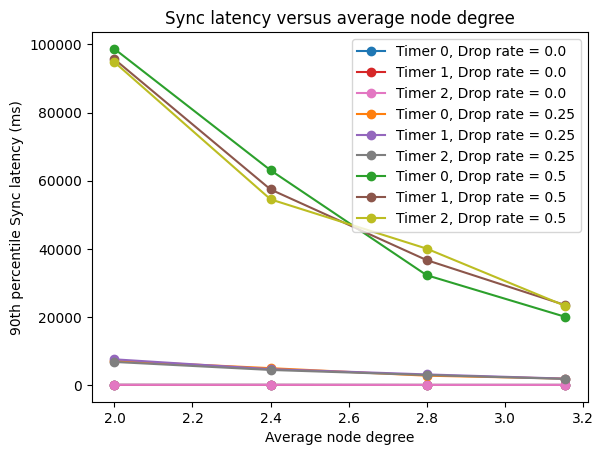

In [9]:
from matplotlib import pyplot as plt

plt.figure()
fig, ax = plt.subplots()
plt.title('Sync latency versus average node degree')
dict_ = {}
dict_[0], dict_[1], dict_[2] = {}, {}, {}
for drop_rate in [0,25,50]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer0_data_37[drop_rate], latencies_timer0_data_24[drop_rate], latencies_timer0_data_12[drop_rate], latencies_timer0_data[drop_rate]], 'o-', label=f'Timer 0, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25,50]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer1_data_37[drop_rate], latencies_timer1_data_24[drop_rate], latencies_timer1_data_12[drop_rate], latencies_timer1_data[drop_rate]], 'o-', label=f'Timer 1, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25,50]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer2_data_37[drop_rate], latencies_timer2_data_24[drop_rate], latencies_timer2_data_12[drop_rate], latencies_timer2_data[drop_rate]], 'o-', label=f'Timer 2, Drop rate = {drop_rate/100}')    
handles, labels = ax.get_legend_handles_labels()
order = [0,3,6,1,4,7,2,5,8]
ax.legend([handles[i] for i in order], [labels[i] for i in order])
plt.xlabel('Average node degree')
plt.ylabel('90th percentile Sync latency (ms)')

Text(0, 0.5, '90th percentile Sync latency (ms)')

<Figure size 640x480 with 0 Axes>

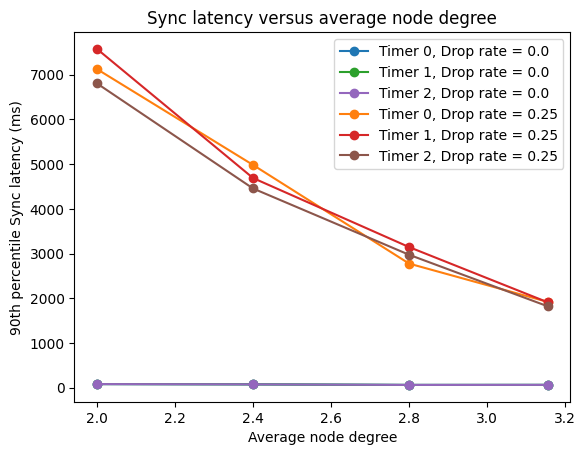

In [10]:
plt.figure()
fig, ax = plt.subplots()
plt.title('Sync latency versus average node degree')
dict_ = {}
dict_[0], dict_[1], dict_[2] = {}, {}, {}
for drop_rate in [0,25]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer0_data_37[drop_rate], latencies_timer0_data_24[drop_rate], latencies_timer0_data_12[drop_rate], latencies_timer0_data[drop_rate]], 'o-', label=f'Timer 0, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer1_data_37[drop_rate], latencies_timer1_data_24[drop_rate], latencies_timer1_data_12[drop_rate], latencies_timer1_data[drop_rate]], 'o-', label=f'Timer 1, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [latencies_timer2_data_37[drop_rate], latencies_timer2_data_24[drop_rate], latencies_timer2_data_12[drop_rate], latencies_timer2_data[drop_rate]], 'o-', label=f'Timer 2, Drop rate = {drop_rate/100}')    
handles, labels = ax.get_legend_handles_labels()
order = [0,2,4,1,3,5]
ax.legend([handles[i] for i in order], [labels[i] for i in order])
plt.xlabel('Average node degree')
plt.ylabel('90th percentile Sync latency (ms)')

Text(0, 0.5, 'Total Sync Interest count')

<Figure size 640x480 with 0 Axes>

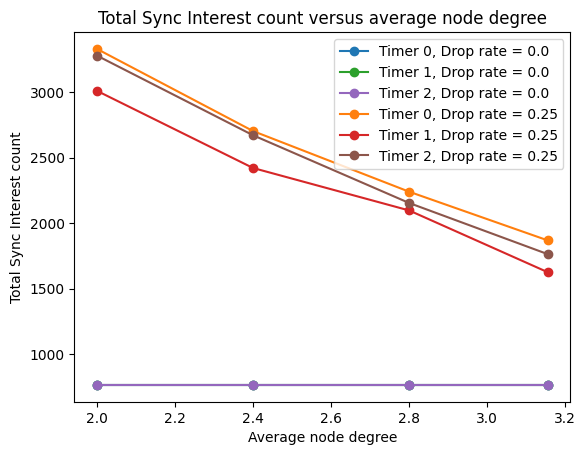

In [11]:
plt.figure()
fig, ax = plt.subplots()
plt.title('Total Sync Interest count versus average node degree')
dict_ = {}
dict_[0], dict_[1], dict_[2] = {}, {}, {}
for drop_rate in [0,25]:
    dict_[0][drop_rate], = ax.plot(topo_degree, [overheads_timer0_data_37[drop_rate], overheads_timer0_data_24[drop_rate], overheads_timer0_data_12[drop_rate], overheads_timer0_data[drop_rate]], 'o-', label=f'Timer 0, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25]:
    dict_[1][drop_rate], = ax.plot(topo_degree, [overheads_timer1_data_37[drop_rate], overheads_timer1_data_24[drop_rate], overheads_timer1_data_12[drop_rate], overheads_timer1_data[drop_rate]], 'o-', label=f'Timer 1, Drop rate = {drop_rate/100}')    
for drop_rate in [0,25]:
    dict_[2][drop_rate], = ax.plot(topo_degree, [overheads_timer2_data_37[drop_rate], overheads_timer2_data_24[drop_rate], overheads_timer2_data_12[drop_rate], overheads_timer2_data[drop_rate]], 'o-', label=f'Timer 2, Drop rate = {drop_rate/100}')    

handles, labels = ax.get_legend_handles_labels()
order = [0,2,4,1,3,5]
ax.legend([handles[i] for i in order], [labels[i] for i in order])
plt.xlabel('Average node degree')
plt.ylabel('Total Sync Interest count')